# **Chapter 7**
## *Handling Missing Data*, 

This chapter explores different methods for identifying and handling missing data. You will learn different imputation and interpolation techniques. The chapter starts with simple statistical methods for univariate imputation and then explores various univariate interpolation algorithms for more advanced multivariate imputation.

In this chapter, you will explore techniques to handle missing data through **imputation** and **interpolation**.  

Here is the list of recipes that we will cover in this chapter:
* Performing data quality checks
* Handling missing data with univariate imputation using pandas
* Handling missing data with univariate imputation using scikit-learn
* Handling missing data with multivariate imputation
* Handling missing data with interpolation

# Technical Requirements
* In this chapter, two datasets will be used extensively for the imputation and interpolation recipes: 
    * the CO2 Emissions dataset, and the e-Shop Clickstream dataset. The source for the Clickstream dataset comes from clickstream data for online shopping from the UCI machine learning repository, which you can find here: https://archive.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping
    * The source for the CO2 emissions dataset comes from the Annual CO2 emissions report from Our World in Data, which you can find here: https://ourworldindata.org/ co2-emissions.

In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np

In [4]:
import matplotlib
import sklearn
import statsmodels as sm

print(f'''
pandas -> {pd.__version__}
numpy -> {np.__version__}
matplotlob -> {matplotlib.__version__}
statsmodels -> {sm.__version__}
scikit-learn -> {sklearn.__version__}
''')


pandas -> 2.2.3
numpy -> 1.26.4
matplotlob -> 3.9.2
statsmodels -> 0.14.4
scikit-learn -> 1.5.2



## Preparing for the recipes of this chapter

## Functions used
* Create all necessary functions that will be used
### `read_datesets()`

In [7]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a date_col to use as index_col 
    
    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder+'/'+ file,        # Read CSV file from specified folder
                     index_col=date_col,      # Set date_col as index (if provided)
                     parse_dates=[date_col])  # Convert date_col to datetime format
    
    return df                                 # Return the loaded DataFrame

### `plot_dfs()`

In [9]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data              # DataFrame containing complete data
    df2: dataframe with missing data                          # DataFrame with missing values
    col: column name that contains missing data               # Column to analyze for missing values
    '''    
    df_missing = df2.rename(columns={col: 'missing'})         # Rename target column for clarity
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()  # Get list of columns from missing data
    subplots_size = len(columns)                              # Determine number of subplots
    
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)   # Create subplots
    plt.subplots_adjust(hspace=0.25)                          # Adjust space between subplots
    fig.suptitle = title                                      # Set main title of the figure
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))                 # Plot original data
    ax[0].set_title('Original Dataset')                       # Title for original dataset
    ax[0].set_xlabel(xlabel)                                  # Set x-axis label
    ax[0].set_ylabel(ylabel)                                  # Set y-axis label    
    
    for i, colname in enumerate(columns):                     # Iterate through missing data columns
        df_missing[colname].plot(ax=ax[i+1])                  # Plot each missing data column
        ax[i+1].set_title(colname)                            # Set title for each missing data plot

    plt.show()                                                # Display the plot

### `rmse_score()`

In [11]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data              # DataFrame with complete data
    df2: dataframe with missing data                          # DataFrame with missing values
    col: column name that contains missing data               # Target column for RMSE calculation

    returns: a list of scores                                 # List of RMSE values for each comparison column
    '''
    df_missing = df2.rename(columns={col: 'missing'})         # Rename target column for clarity
    columns = df_missing.loc[:, 'missing':].columns.tolist()  # Get list of columns to compare
    scores = []                                               # Initialize list to store RMSE values

    for comp_col in columns[1:]:                                       # Iterate through missing data columns (excluding the first)
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))  # Compute RMSE
        scores.append(rmse)                                            # Store RMSE value in list
        print(f'RMSE for {comp_col}: {rmse}')                          # Print RMSE for each column
    
    return scores                                             # Return list of RMSE scores

# Recipe 1: Perform Data Quality Checks
* Examples of missing data
* Understand `NaN` vs `NaT`
* Identify missing observations that are replaced with other values in the source system but should be considered as missing
* Explain `na_values` and `keep_default_na` parameters 

In [13]:
# Urls
co2 = ('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/refs/heads/main/datasets/Ch7/co2_missing.csv')
ecom = ('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/refs/heads/main/datasets/Ch7/clicks_missing_multiple.csv')

# Dataframes
co2_df = pd.read_csv(co2)
ecom_df = pd.read_csv(ecom, parse_dates=['date'], date_format='mixed')

In [14]:
co2_df.shape

(226, 2)

In [15]:
ecom_df.head()

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784
1,2008-04-02,43.079056,1.0,24738
2,NaT,43.842609,NaN,15209
3,NaT,NaN,1.0,14018
4,NaT,43.941176,1.0,11974


In [16]:
co2_df.head()

,year,co2
0,1750,0.0125
1,1760,0.0128
2,1770,0.0150
3,1780,0.0169
4,1790,0.0206


In [17]:
co2_df.isnull().sum()

year     0
co2     25
dtype: int64

In [18]:
# using isna()
co2_df.isna().sum()

year     0
co2     25
dtype: int64

In [19]:
ecom_df.isna().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [20]:
# using isnull()
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      14
dtype: int64

In [21]:
# using isnull()
ecom_df.isnull().sum().sum()

20

In [22]:
co2_df[190:195]

,year,co2
190,1985,NaN
191,1986,NaN
192,1987,NaN
193,1988,4.2953
194,1989,4.2782


In [23]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [24]:
ecom_df.isnull().values.any()

True

In [25]:
co2_df.isnull().values.any()

True

In [26]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [27]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    226 non-null    int64  
 1   co2     201 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.7 KB


In [28]:
co2_df['year'] = pd.to_datetime(co2_df['year'], format='%Y')  # Convert year to datetime
#co2_df.set_index('year', inplace=True)                        # Set datetime as index

co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    226 non-null    datetime64[ns]
 1   co2     201 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.7 KB


In [29]:
co2_df.describe(include='all')

,year,co2
count,226,201.000000
mean,1906-11-27 01:29:12.212389376,1.590015
min,1750-01-01 00:00:00,0.000000
25%,1851-04-02 06:00:00,0.076400
50%,1907-07-02 12:00:00,0.935100
75%,1963-10-01 18:00:00,2.807600
max,2020-01-01 00:00:00,4.907900
std,NaN,1.644182


In [30]:
ecom_df.describe(include='all')

,date,price,location,clicks
count,131,134.000000,134.000000,121
unique,NaN,NaN,NaN,119
top,NaN,NaN,NaN,?
freq,NaN,NaN,NaN,2
mean,2008-06-08 22:32:03.664122112,43.480221,1.694030,NaN
min,2008-04-01 00:00:00,42.207018,1.000000,NaN
25%,2008-05-07 12:00:00,43.038050,1.000000,NaN
50%,2008-06-09 00:00:00,43.498842,1.000000,NaN
75%,2008-07-11 12:00:00,43.889935,2.000000,NaN
max,2008-08-13 00:00:00,45.801613,5.000000,NaN


In [31]:
test = pd.read_csv(ecom, parse_dates=['date'], na_values={'?'}, date_format='mixed')

test.head()

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0


In [32]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      131 non-null    datetime64[ns]
 1   price     134 non-null    float64       
 2   location  134 non-null    float64       
 3   clicks    121 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.3+ KB


In [33]:
co2_df.replace(0, np.NaN, inplace=True)
ecom_df.replace('?', np.NaN, inplace=True)
ecom_df['clicks'] = ecom_df['clicks'].astype('float')

In [34]:
co2_df.isnull().sum()

year     0
co2     35
dtype: int64

In [35]:
ecom_df.isnull().sum()

date         4
price        1
location     1
clicks      16
dtype: int64

## How it works

In [37]:
co2_df = pd.read_csv(co2, keep_default_na=False)

In [38]:
co2_df.iloc[132:139]

,year,co2
132,1927,
133,1928,
134,1929,
135,1930,
136,1931,
137,1932,
138,1933,


In [39]:
co2_df.iloc[132:139]['co2'] == ''

132    True
133    True
134    True
135    True
136    True
137    True
138    True
Name: co2, dtype: bool

In [40]:
co2_df.isna().sum()

year    0
co2     0
dtype: int64

In [41]:
co2_df.shape

(226, 2)

In [42]:
co2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    226 non-null    int64 
 1   co2     226 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.7+ KB


In [43]:
co2_df[190:195]

,year,co2
190,1985,NA
191,1986,N/A
192,1987,null
193,1988,4.2953
194,1989,4.2782


In [44]:
co2_df.isnull().sum()
co2_df.isnull().sum().sum()

0

### There is More

In [46]:
pd.read_csv(ecom, parse_dates=['date'], na_values={'?'}, date_format='mixed')

,date,price,location,clicks
0,2008-04-01,43.155647,2.0,18784.0
1,2008-04-02,43.079056,1.0,24738.0
2,NaT,43.842609,NaN,15209.0
3,NaT,NaN,1.0,14018.0
4,NaT,43.941176,1.0,11974.0
...,...,...,...,...
130,2008-08-09,44.182033,1.0,6716.0
131,2008-08-10,43.608260,1.0,9523.0
132,2008-08-11,43.553363,1.0,8881.0
133,2008-08-12,44.500469,1.0,7272.0


In [47]:
pd.read_csv(ecom, parse_dates=['date'], na_values={'?'}).isna().sum()

C:\Users\lsoares\AppData\Local\Temp\ipykernel_22776\2106754234.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(ecom, parse_dates=['date'], na_values={'?'}).isna().sum()


date         4
price        1
location     1
clicks      16
dtype: int64

# Recipe 2: Handling Missing Data with Univariate Imputation using pandas  

Some basic univariate imputation techniques include the following:
* Imputing using the mean.
* Imputing using the last observation forward (forward fill). This can be referred to as Last Observation Carried Forward (LOCF).
* Imputing using the next observation backward (backward fill). This can be referred to as Next Observation Carried Backward (NOCB).  

You will use two datasets to impute missing data using different techniques and then compare the results.

In [49]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

```Python
folder = 'data'

co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')
```

In [51]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a string representing the folder path
    file: the CSV filename in that folder
    date_col: specify a date_col to use as index_col

    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder + '/' + file,      # Read CSV file from folder
                     index_col=date_col,       # Set date_col as index (if provided)
                     parse_dates=[date_col],   # Convert date_col to datetime
                     date_format='%Y') if date_col == 'year' else pd.read_csv(  # Format based on column
                     folder + '/' + file,
                     index_col=date_col,
                     parse_dates=[date_col],
                     date_format='%Y-%m-%d')  # Expected format for 'date' column
    return df

# Define folder
folder = 'data'

# Load datasets
co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')


In [52]:
co2_missing.isnull().sum()

co2    35
dtype: int64

In [53]:
clicks_missing.isnull().sum()

price        0
location     0
clicks      16
dtype: int64

In [54]:
clicks_missing.loc[:, 'missing':].shape[1]

2

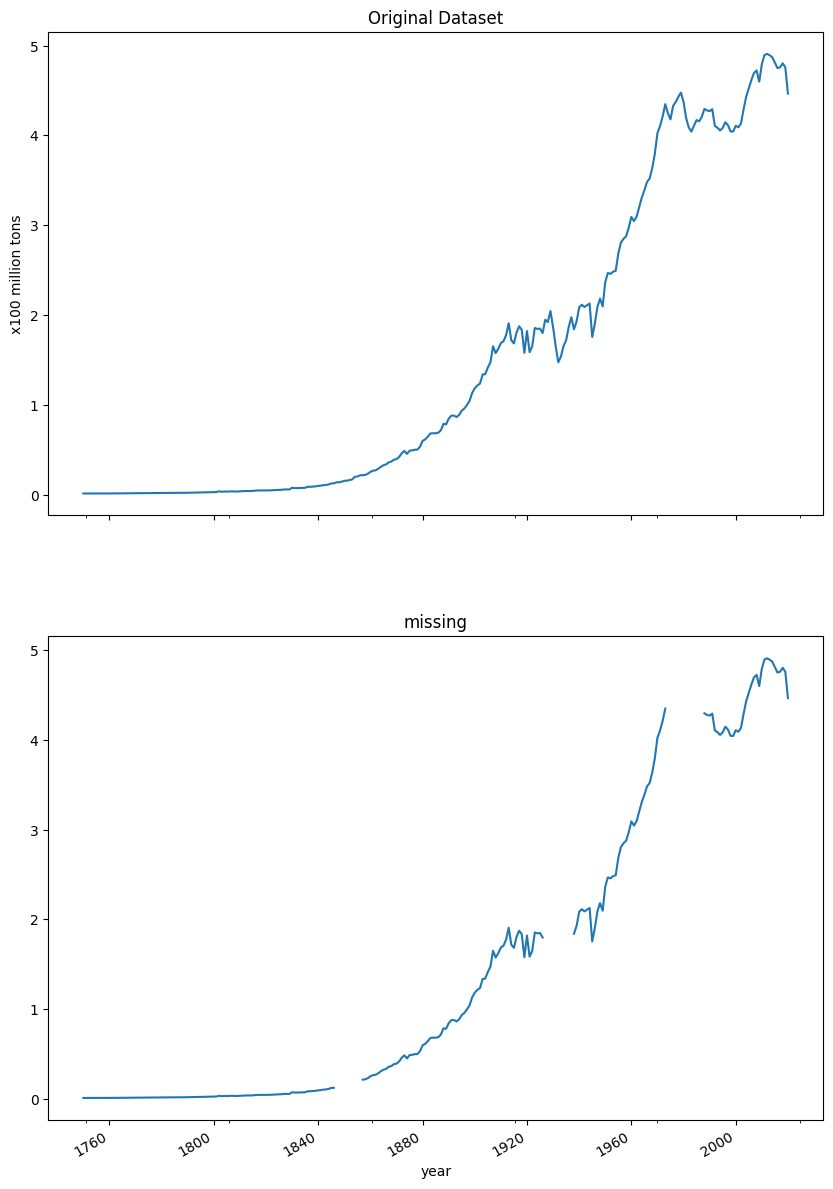

In [55]:
plot_dfs(co2_original, 
         co2_missing, 
         'co2',
         title="Annual CO2 Emission per Capita",
         xlabel="Years",
         ylabel="x100 million tons")

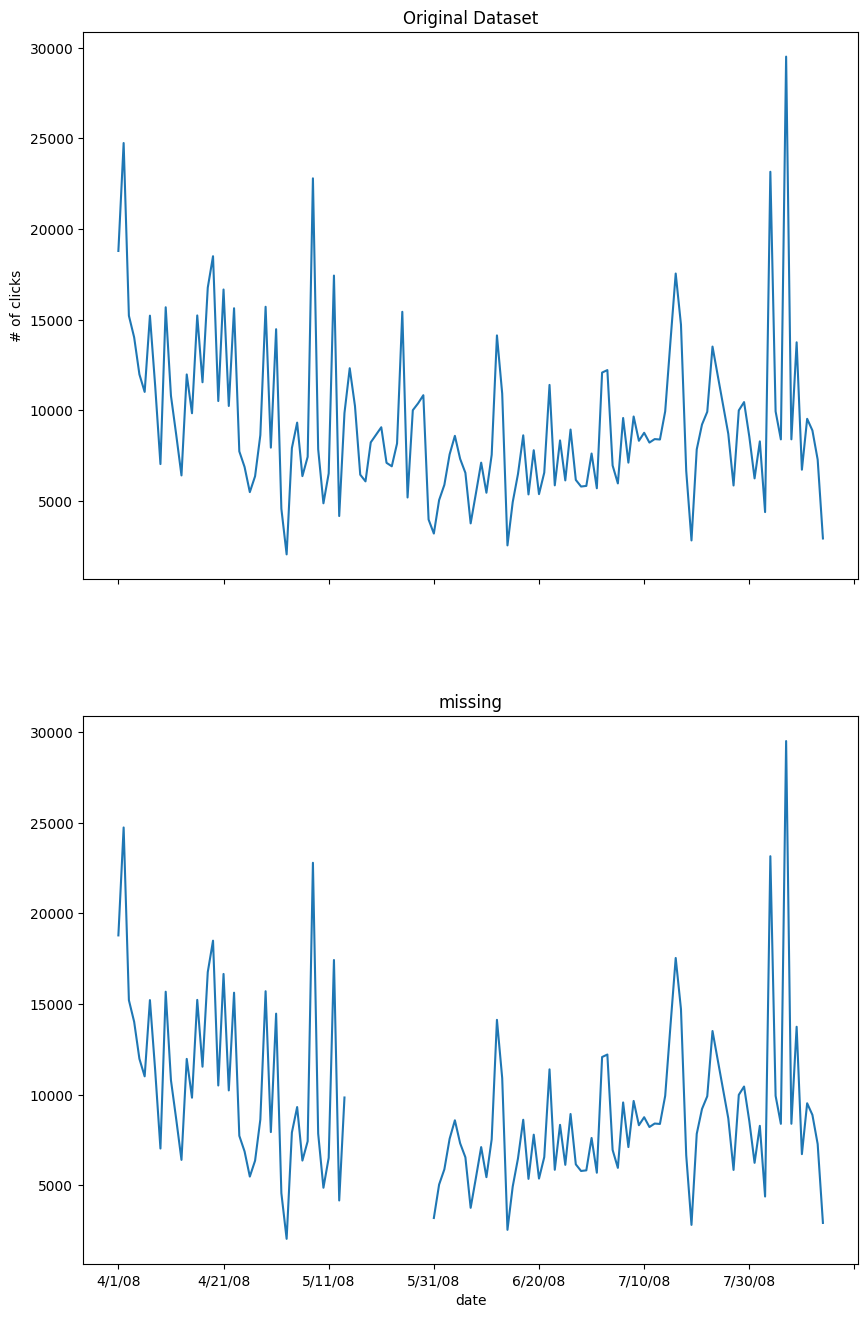

In [56]:
plot_dfs(clicks_original, 
         clicks_missing, 
         'clicks',
         title="Page Clicks per Day",
         xlabel="date",
         ylabel="# of clicks")

**Backward filling** with `.bfill()`, uses the
next observation, after the missing spot(s) and fills the gaps backward. 

**Forward filling** with `.ffill()`, which uses the last value,
before the missing spot(s) and fills the gaps forward.

In [58]:
# Forward fill
co2_missing['ffill'] = co2_missing['co2'].ffill()  

# Backward fill
co2_missing['bfill'] = co2_missing['co2'].bfill()  

# Mean fill (remains unchanged)
co2_missing['mean'] = co2_missing['co2'].fillna(co2_missing['co2'].mean())  

In [59]:
# Compute RMSE scores for different imputation methods
_ = rmse_score(co2_original,       # Original dataframe without missing values
               co2_missing,        # Dataframe with missing values filled using different methods
               'co2')              # Column name to compute RMSE scores for different imputation methods

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684


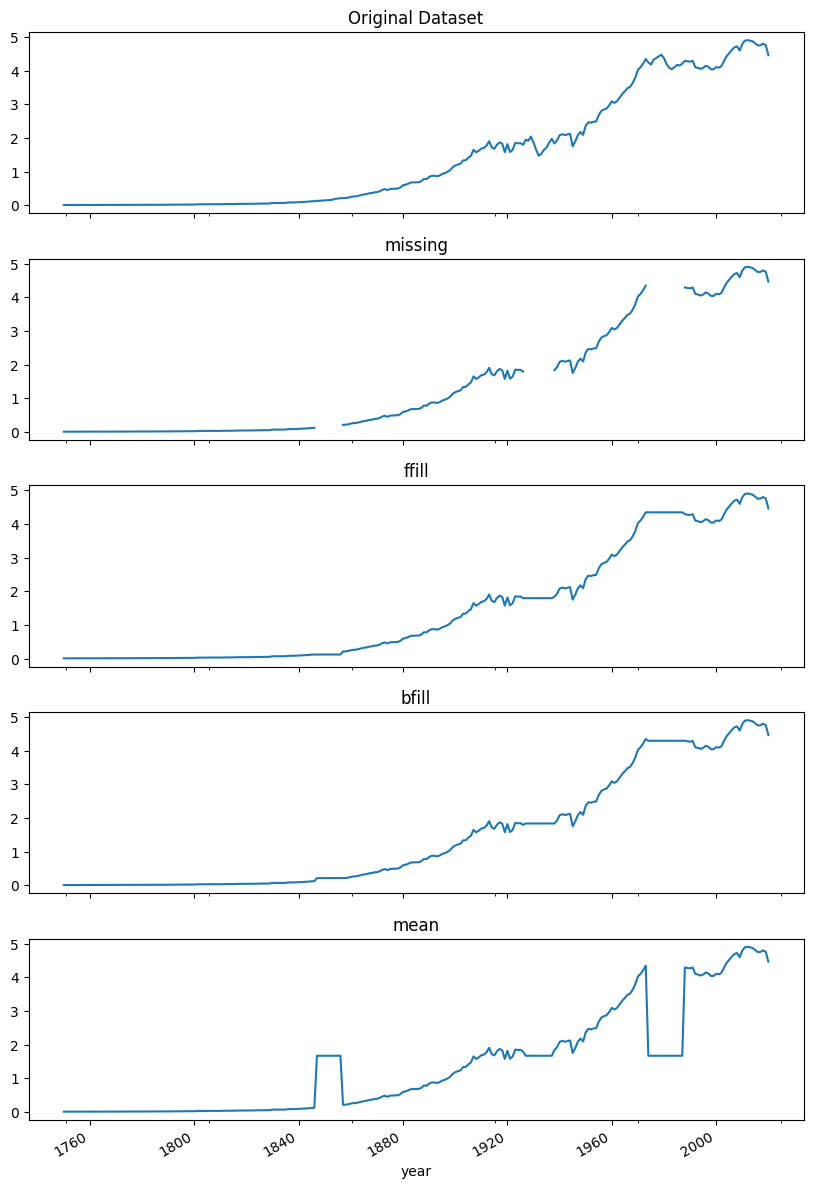

In [60]:
plot_dfs(co2_original, co2_missing, 'co2')

In [61]:
# Forward fill missing values in 'clicks' column
clicks_missing['ffil'] = clicks_missing['clicks'].ffill()

# Backward fill missing values in 'clicks' column
clicks_missing['bfill'] = clicks_missing['clicks'].bfill()

# Fill missing values with the mean of 'clicks' column
clicks_missing['mean'] = clicks_missing['clicks'].fillna(clicks_missing['clicks'].mean())

In [62]:
# Compute RMSE scores for different imputation methods
_ = rmse_score(clicks_original,   # Original dataframe without missing values
               clicks_missing,    # Dataframe with missing values
               'clicks')          # Column containing missing data

RMSE for ffil: 1034.1210689204554
RMSE for bfill: 2116.6840489225033
RMSE for mean: 997.7600138929953


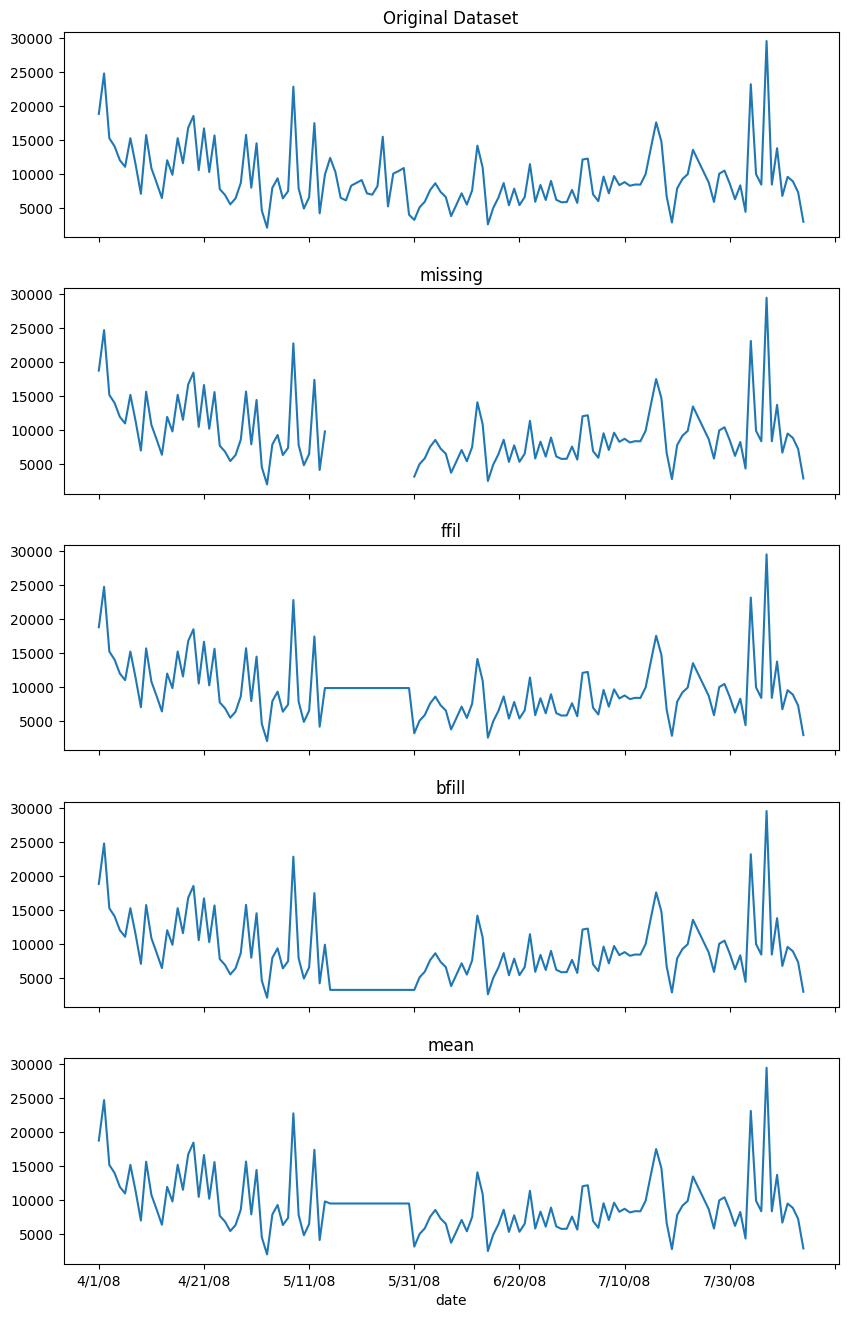

In [63]:
plot_dfs(clicks_original, clicks_missing, 'clicks')

In [64]:
clicks_missing.head()

,price,location,clicks,ffil,bfill,mean
date,,,,,,
4/1/08,43.155647,2,18784.0,18784.0,18784.0,18784.0
4/2/08,43.079056,1,24738.0,24738.0,24738.0,24738.0
4/3/08,43.842609,2,15209.0,15209.0,15209.0,15209.0
4/4/08,43.312376,1,14018.0,14018.0,14018.0,14018.0
4/5/08,43.941176,1,11974.0,11974.0,11974.0,11974.0


In [65]:
clicks_missing.loc['5/10/08':'5/18/08']

,price,location,clicks,ffil,bfill,mean
date,,,,,,
5/10/08,42.576299,1,4863.0,4863.0,4863.0,4863.000000
5/11/08,43.405890,5,6511.0,6511.0,6511.0,6511.000000
5/12/08,43.258326,2,17426.0,17426.0,17426.0,17426.000000
5/13/08,42.714479,2,4160.0,4160.0,4160.0,4160.000000
5/14/08,43.372786,5,9841.0,9841.0,9841.0,9841.000000
5/15/08,42.517755,2,NaN,9841.0,3194.0,9530.336134
5/16/08,44.011009,2,NaN,9841.0,3194.0,9530.336134
5/17/08,42.530303,2,NaN,9841.0,3194.0,9530.336134
5/18/08,42.565698,5,NaN,9841.0,3194.0,9530.336134


In [66]:
clicks_missing.loc['5/30/08':'6/15/08']

,price,location,clicks,ffil,bfill,mean
date,,,,,,
5/30/08,44.558011,5,NaN,9841.0,3194.0,9530.336134
5/31/08,43.100427,2,3194.0,3194.0,3194.0,3194.000000
6/1/08,42.875000,2,5038.0,5038.0,5038.0,5038.000000
6/2/08,43.406951,2,5879.0,5879.0,5879.0,5879.000000
6/3/08,42.957505,5,7563.0,7563.0,7563.0,7563.000000
6/4/08,42.930399,2,8584.0,8584.0,8584.0,8584.000000
6/5/08,42.801887,2,7315.0,7315.0,7315.0,7315.000000
6/6/08,43.740476,2,6541.0,6541.0,6541.0,6541.000000
6/7/08,43.823729,1,3755.0,3755.0,3755.0,3755.000000


In [67]:
clicks_missing[clicks_missing['clicks'].isna()]

,price,location,clicks,ffil,bfill,mean
date,,,,,,
5/15/08,42.517755,2,NaN,9841.0,3194.0,9530.336134
5/16/08,44.011009,2,NaN,9841.0,3194.0,9530.336134
5/17/08,42.530303,2,NaN,9841.0,3194.0,9530.336134
5/18/08,42.565698,5,NaN,9841.0,3194.0,9530.336134
5/19/08,43.892996,2,NaN,9841.0,3194.0,9530.336134
5/20/08,43.247706,2,NaN,9841.0,3194.0,9530.336134
5/21/08,44.106289,1,NaN,9841.0,3194.0,9530.336134
5/22/08,43.810714,1,NaN,9841.0,3194.0,9530.336134
5/23/08,43.620802,1,NaN,9841.0,3194.0,9530.336134


### There is More

In [69]:
co2_missing['co2'].ffill()        # Forward fill missing values in the 'co2' column
co2_missing['co2'].bfill()        # Backward fill missing values in the 'co2' column
clicks_missing['clicks'].ffill()  # Forward fill missing values in the 'clicks' column
clicks_missing['clicks'].bfill()  # Backward fill missing values in the 'clicks' column

date
4/1/08     18784.0
4/2/08     24738.0
4/3/08     15209.0
4/4/08     14018.0
4/5/08     11974.0
            ...   
8/9/08      6716.0
8/10/08     9523.0
8/11/08     8881.0
8/12/08     7272.0
8/13/08     2922.0
Name: clicks, Length: 135, dtype: float64

# Recipe 3: Handling Missing Data with Univariate Imputation using Scikit-Learn
* Using Sckit-Learn `SimpleImputer`

In [71]:
from sklearn.impute import SimpleImputer

In [72]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a string representing the folder path
    file: the CSV filename in that folder
    date_col: specify a date_col to use as index_col

    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder + '/' + file,      # Read CSV file from folder
                     index_col=date_col,       # Set date_col as index (if provided)
                     parse_dates=[date_col],   # Convert date_col to datetime
                     date_format='%Y') if date_col == 'year' else pd.read_csv(  # Format based on column
                     folder + '/' + file,
                     index_col=date_col,
                     parse_dates=[date_col],
                     date_format='%Y-%m-%d')  # Expected format for 'date' column
    return df

# Define folder
folder = 'data'

# Load datasets
co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')

In [73]:
strategy = [
    ('Mean Strategy', 'mean'),
    ('Median Strategy', 'median'),
    ('Most Frequent Strategy', 'most_frequent')]

In [74]:
co2_vals = co2_missing['co2'].values.reshape(-1,1)           # Reshape 'co2' column to a 2D array for imputation
clicks_vals = clicks_missing['clicks'].values.reshape(-1,1)  # Reshape 'clicks' column to a 2D array for imputation

# Iterate over different imputation strategies
for s_name, s in strategy:  
    co2_missing[s_name] = (                                  # Apply imputation strategy to 'co2' column
        SimpleImputer(strategy=s).fit_transform(co2_vals))  
    clicks_missing[s_name] = (                               # Apply imputation strategy to 'clicks' column
        SimpleImputer(strategy=s).fit_transform(clicks_vals))  

In [75]:
# Compute RMSE scores for different imputation strategies on 'co2' column
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for Mean Strategy: 0.7156383637041684
RMSE for Median Strategy: 0.802942160685986
RMSE for Most Frequent Strategy: 1.1245663822743381


In [76]:
# Compute RMSE scores for different imputation strategies on 'clicks' column
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for Mean Strategy: 997.7600138929953
RMSE for Median Strategy: 959.3580492530756
RMSE for Most Frequent Strategy: 1097.6425985146868


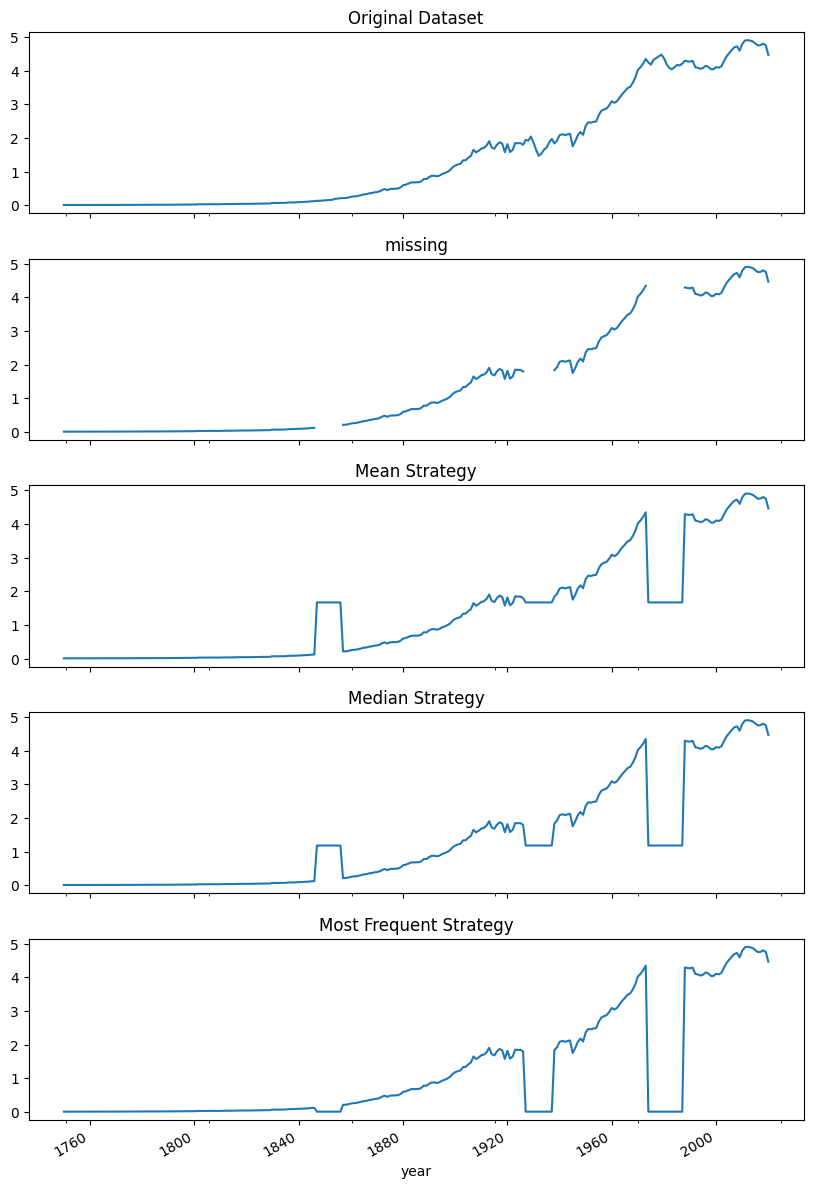

In [77]:
# Plot original and missing data for the 'co2' column with different imputation methods
plot_dfs(co2_original, co2_missing, 'co2')

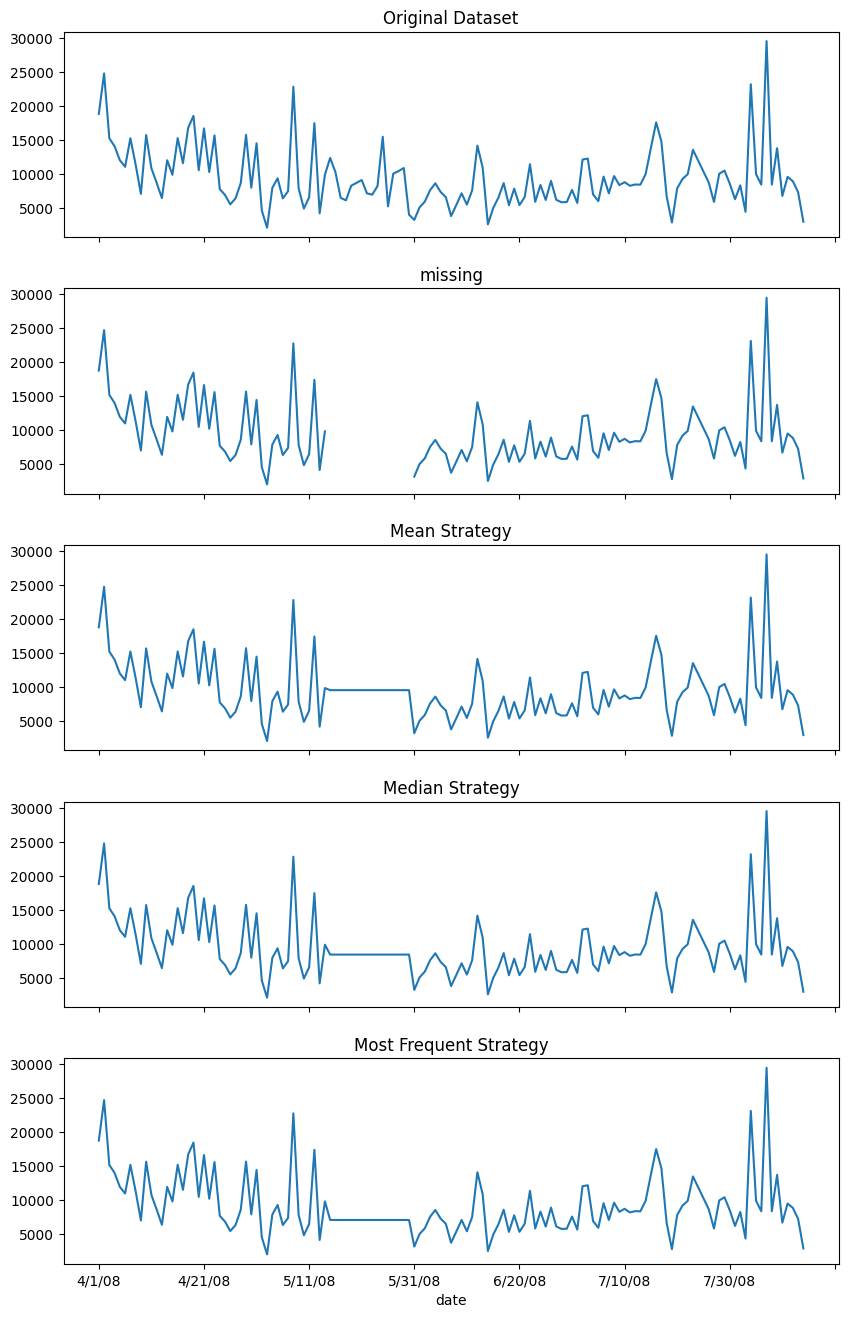

In [78]:
# Plot original and missing data for the 'clicks' column with different imputation methods
plot_dfs(clicks_original, clicks_missing, 'clicks')

## There is more

In [80]:
avg = co2_missing['co2'].mean()                               # Calculate the mean of the 'co2' column
co2_missing['pands_fillna'] = co2_missing['co2'].fillna(avg)  # Fill NaN values in 'co2' with the calculated mean

co2_missing

,co2,Mean Strategy,Median Strategy,Most Frequent Strategy,pands_fillna
year,,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206,0.0206
...,...,...,...,...,...
2016-01-01,4.7496,4.7496,4.7496,4.7496,4.7496
2017-01-01,4.7595,4.7595,4.7595,4.7595,4.7595
2018-01-01,4.8022,4.8022,4.8022,4.8022,4.8022


In [81]:
cols = ['co2', 'Mean Strategy', 'pands_fillna']         # Define columns to evaluate
_ = rmse_score(co2_original, co2_missing[cols], 'co2')  # Compute RMSE for selected columns

RMSE for Mean Strategy: 0.7156383637041684
RMSE for pands_fillna: 0.7156383637041684


# Recipe 4: Handling Missing Data with Multivariate Imputation
* In this recipe, you will be working with the Clickstream dataset since it has additional variables (clicks, price, and location columns) to perform multivariate imputation for clicks.
* Using Scikit-Learn `IterativeImputer`
* Using statsmodels `MICE` implementation

In [83]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [84]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a string representing the folder path
    file: the CSV filename in that folder
    date_col: specify a date_col to use as index_col

    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder + '/' + file,      # Read CSV file from folder
                     index_col=date_col,       # Set date_col as index (if provided)
                     parse_dates=[date_col],   # Convert date_col to datetime
                     date_format='%Y') if date_col == 'year' else pd.read_csv(  # Format based on column
                     folder + '/' + file,
                     index_col=date_col,
                     parse_dates=[date_col],
                     date_format='%Y-%m-%d')  # Expected format for 'date' column
    return df

# Define folder
folder = 'data'

# Load datasets
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')

In [85]:
clicks_missing.isna().sum()

price        0
location     0
clicks      16
dtype: int64

In [86]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [87]:
# Define a list of estimators for imputation
estimators = [  
    ('bayesianRidge', BayesianRidge()),                     # Bayesian Ridge Regression
    ('extra_trees', ExtraTreesRegressor(n_estimators=10)),  # Extra Trees Regressor
    ('bagging', BaggingRegressor(n_estimators=10)),         # Bagging Regressor
    ('elastic_net', ElasticNet()),                          # Elastic Net Regression
    ('linear_regression', LinearRegression()),              # Linear Regression
    ('knn', KNeighborsRegressor(n_neighbors=3))             # K-Nearest Neighbors Regressor
]

clicks_vals = clicks_missing.iloc[:,0:3].values       # Extract first three columns as input values

for e_name, e in estimators:                                    # Iterate over each estimator
    est = IterativeImputer(                                     # Initialize IterativeImputer with the estimator
                random_state=15,                                # Set random state for reproducibility
                estimator=e,                                    # Fit the imputer on the data
                max_iter=50).fit(clicks_vals)                   # Max number of interactions                 
    clicks_missing[e_name] = est.transform(clicks_vals)[: , 2]  # Impute missing values and update the dataframe

In [88]:
# Compute RMSE for imputed values in 'clicks' column
_ = rmse_score(clicks_original, clicks_missing, 'clicks')  

RMSE for bayesianRidge: 949.4393973455849
RMSE for extra_trees: 1775.0240048037745
RMSE for bagging: 1283.006675511631
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427183
RMSE for knn: 1336.8798392251822


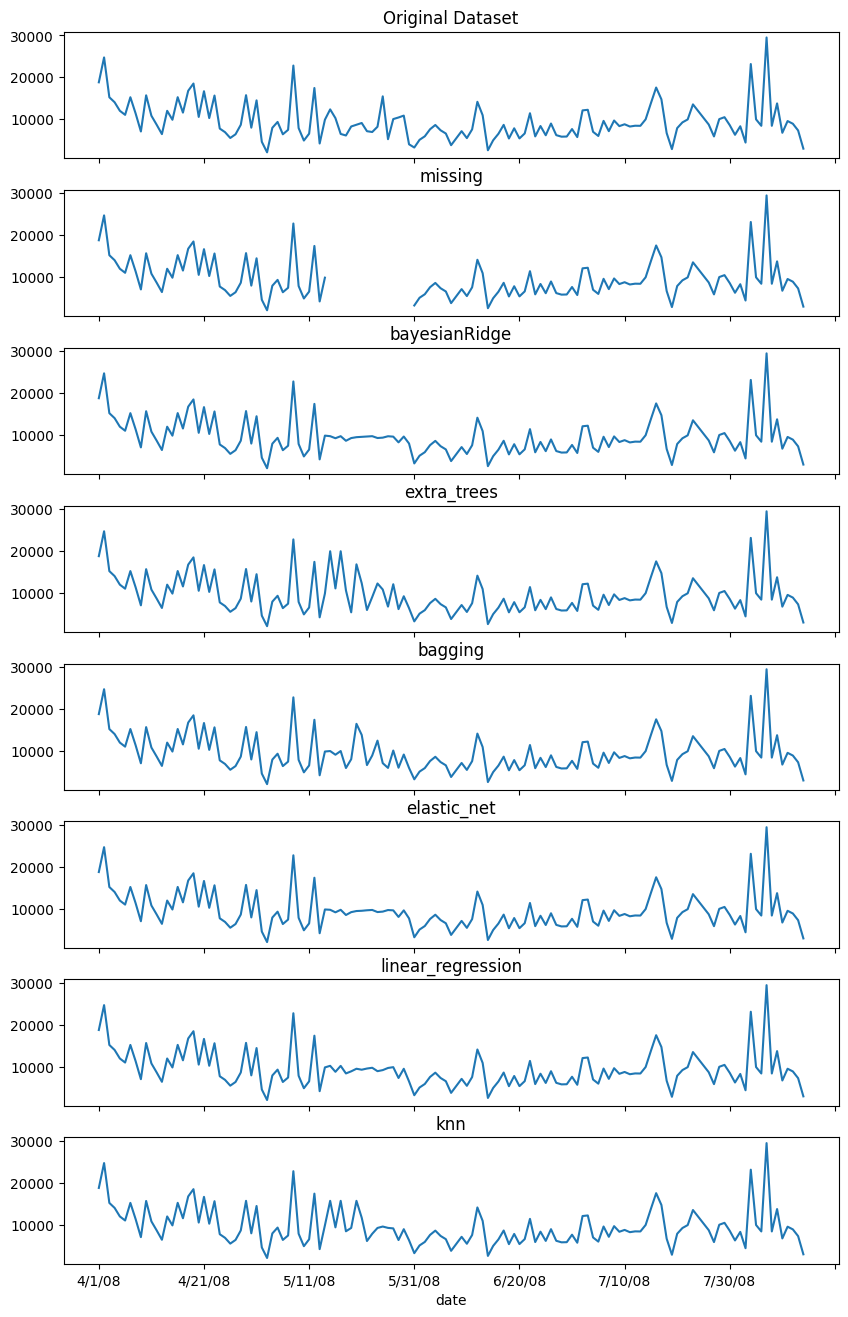

In [89]:
# Plot original vs. imputed data for 'clicks'
plot_dfs(clicks_original, clicks_missing, 'clicks')

### There is more

In [91]:
from statsmodels.imputation.mice import MICE, MICEData, MICEResults
import statsmodels.api as sm

In [92]:
# Create a MICEData object for multiple imputation
fltr = ['price', 'location', 'clicks']                                      # Select relevant columns for imputation
mice_data = MICEData(clicks_missing[fltr], perturbation_method='gaussian')  # Apply Gaussian perturbation

# Perform 20 iterations of the imputation process
mice_data.update_all(n_iter=20)

# Set the imputer for 'clicks' using a linear regression model (OLS)
mice_data.set_imputer('clicks', formula='~ price + location', model_class=sm.OLS)

In [93]:
# Store the imputed values for 'clicks' from MICEData into the original dataframe
clicks_missing['MICE'] = mice_data.data['clicks'].values.tolist()

In [94]:
# Compute RMSE scores for different imputation methods in 'clicks_missing' compared to the original data
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for bayesianRidge: 949.4393973455849
RMSE for extra_trees: 1775.0240048037745
RMSE for bagging: 1283.006675511631
RMSE for elastic_net: 945.4075209343101
RMSE for linear_regression: 938.9419831427183
RMSE for knn: 1336.8798392251822
RMSE for MICE: 2123.2999351987028


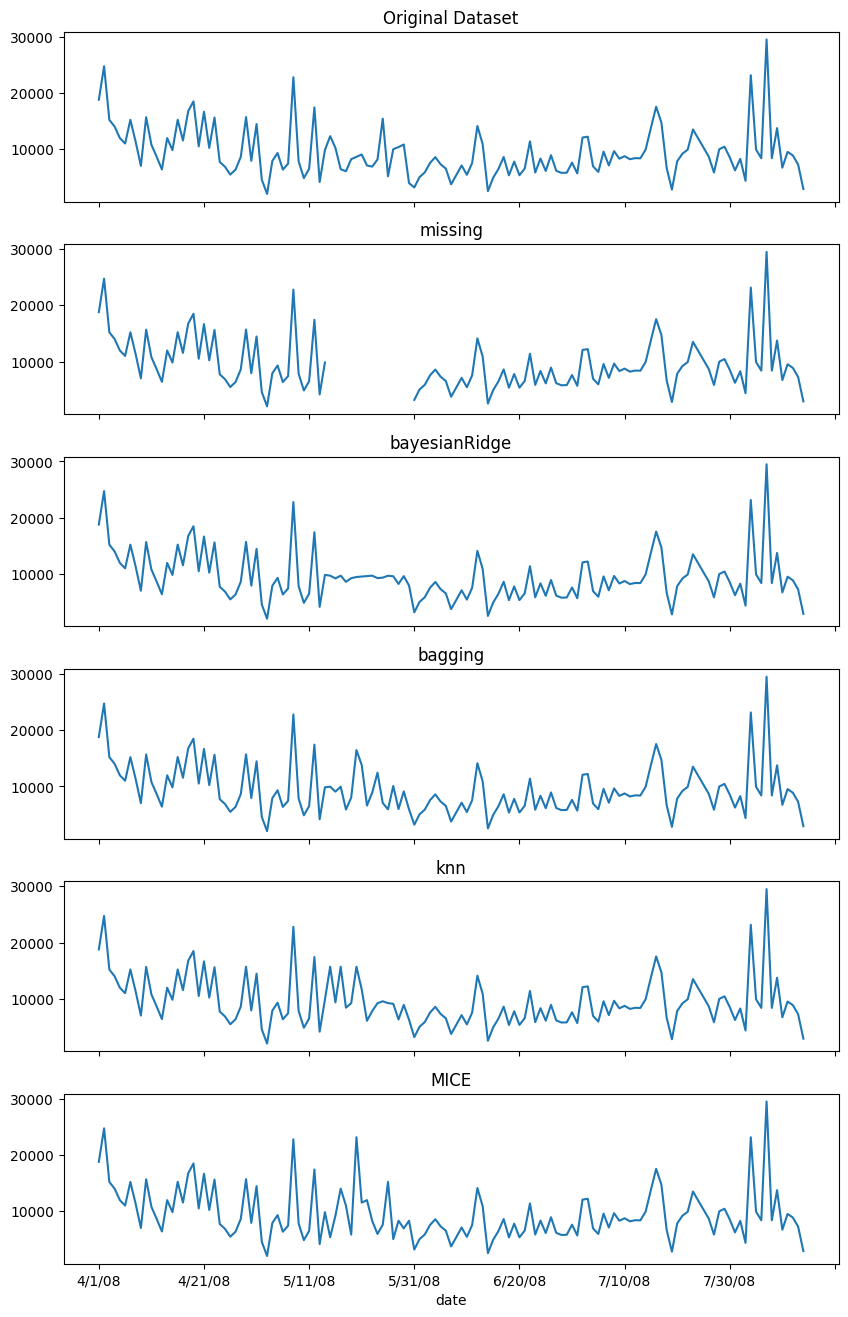

In [95]:
# Define columns to be compared in the plot
cols = ['clicks', 'bayesianRidge', 'bagging', 'knn', 'MICE']

# Plot the original data along with different imputation strategies
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

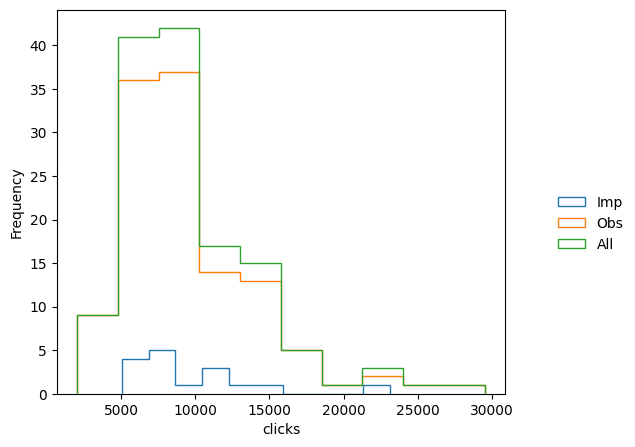

In [96]:
# Plot histogram of imputed values for 'clicks' to compare with observed data
_ = mice_data.plot_imputed_hist('clicks')

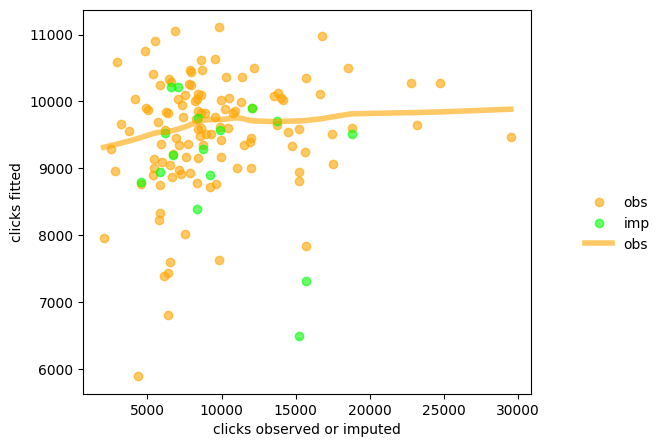

In [97]:
# Create a MICEData object with Gaussian perturbation for multiple imputation
mice_data = MICEData(clicks_missing[fltr], 
                     perturbation_method='gaussian')

# Perform 20 iterations of imputation updates
mice_data.update_all(n_iter=20)

# Plot the observed vs. fitted values for the 'clicks' variable
_ = mice_data.plot_fit_obs('clicks')

# Recipe 4: Handling Missing Data with Interpolation
* In this recipe, you will use the`.interpolate()` function to examine different interpolation methods, including `linear`, `polynomial`, `quadratic`, `nearest`, and `spline`.

In [99]:
def read_dataset(folder, file, date_col=None):
    '''
    folder: is a string representing the folder path
    file: the CSV filename in that folder
    date_col: specify a date_col to use as index_col

    returns: a pandas DataFrame with a DatetimeIndex
    '''
    df = pd.read_csv(folder + '/' + file,      # Read CSV file from folder
                     index_col=date_col,       # Set date_col as index (if provided)
                     parse_dates=[date_col],   # Convert date_col to datetime
                     date_format='%Y') if date_col == 'year' else pd.read_csv(  # Format based on column
                     folder + '/' + file,
                     index_col=date_col,
                     parse_dates=[date_col],
                     date_format='%Y-%m-%d')  # Expected format for 'date' column
    return df

# Define folder
folder = 'data'

# Load datasets
co2_original = read_dataset(folder, 'co2_original.csv', 'year')
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year')
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date')
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date')

#### co2_missing

In [101]:
# Perform interpolation to fill missing values in the 'co2_missing' DataFrame
co2_missing.interpolate()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206
...,...
2016-01-01,4.7496
2017-01-01,4.7595
2018-01-01,4.8022


In [102]:
# Rename the index to 'date'
co2_missing.index.name = 'date'

co2_missing

,co2
date,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206
...,...
2016-01-01,4.7496
2017-01-01,4.7595
2018-01-01,4.8022


### co2_original

In [104]:
co2_original

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206
...,...
2016-01-01,4.7496
2017-01-01,4.7595
2018-01-01,4.8022


In [105]:
# Rename the index to 'date'
co2_original.index.name = 'date'

co2_original

,co2
date,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206
...,...
2016-01-01,4.7496
2017-01-01,4.7595
2018-01-01,4.8022


### clicks_missing

In [107]:
clicks_missing

,price,location,clicks
date,,,
4/1/08,43.155647,2,18784.0
4/2/08,43.079056,1,24738.0
4/3/08,43.842609,2,15209.0
4/4/08,43.312376,1,14018.0
4/5/08,43.941176,1,11974.0
...,...,...,...
8/9/08,44.182033,1,6716.0
8/10/08,43.608260,1,9523.0
8/11/08,43.553363,1,8881.0


In [108]:
# Ensure the index is in datetime format
clicks_missing.index = pd.to_datetime(clicks_missing.index, errors='coerce')

# Convert the index to string format 'YYYY-MM-DD'
clicks_missing.index = clicks_missing.index.map(lambda x: x.strftime('%Y-%m-%d') if pd.notnull(x) else x)

clicks_missing

,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784.0
2008-04-02,43.079056,1,24738.0
2008-04-03,43.842609,2,15209.0
2008-04-04,43.312376,1,14018.0
2008-04-05,43.941176,1,11974.0
...,...,...,...
2008-08-09,44.182033,1,6716.0
2008-08-10,43.608260,1,9523.0
2008-08-11,43.553363,1,8881.0


### clicks_original

In [110]:
clicks_original

,price,location,clicks
date,,,
4/1/08,43.155647,2,18784
4/2/08,43.079056,1,24738
4/3/08,43.842609,2,15209
4/4/08,43.312376,1,14018
4/5/08,43.941176,1,11974
...,...,...,...
8/9/08,44.182033,1,6716
8/10/08,43.608260,1,9523
8/11/08,43.553363,1,8881


In [111]:
# Ensure the index is in datetime format
clicks_original.index = pd.to_datetime(clicks_original.index, errors='coerce')

# Convert the index to string format 'YYYY-MM-DD'
clicks_original.index = clicks_original.index.map(lambda x: x.strftime('%Y-%m-%d') if pd.notnull(x) else x)

clicks_original

,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784
2008-04-02,43.079056,1,24738
2008-04-03,43.842609,2,15209
2008-04-04,43.312376,1,14018
2008-04-05,43.941176,1,11974
...,...,...,...
2008-08-09,44.182033,1,6716
2008-08-10,43.608260,1,9523
2008-08-11,43.553363,1,8881


In [112]:
# Convert index to datetime
co2_missing.index = pd.to_datetime(co2_missing.index, errors='coerce')
co2_original.index = pd.to_datetime(co2_original.index, errors='coerce')
clicks_original.index = pd.to_datetime(clicks_original.index, errors='coerce')
clicks_missing.index = pd.to_datetime(clicks_missing.index, errors='coerce')

In [113]:
# Define different interpolation methods
interpolations = [
    'linear',       # Linear interpolation
    'quadratic',    # Quadratic interpolation
    'nearest',      # Nearest-neighbor interpolation
    'cubic'         # Cubic spline interpolation
]

# Apply interpolation methods
for intp in interpolations:
    co2_missing[intp] = co2_missing['co2'].interpolate(method=intp)           
    clicks_missing[intp] = clicks_missing['clicks'].interpolate(method=intp)  

# Apply spline interpolation with order 3
co2_missing['spline'] = co2_missing['co2'].interpolate(method='spline', order=3)  
clicks_missing['spline'] = clicks_missing['clicks'].interpolate(method='spline', order=3)

# Apply polynomial interpolation with order 3
co2_missing['polynomial'] = co2_missing['co2'].interpolate(method='polynomial', order=3)  
clicks_missing['polynomial'] = clicks_missing['clicks'].interpolate(method='polynomial', order=3)

In [114]:
_ = rmse_score(co2_original, co2_missing, 'co2')

RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614346
RMSE for nearest: 0.05385422309469095
RMSE for cubic: 0.08373627305833138
RMSE for spline: 0.17765043760996152
RMSE for polynomial: 0.08373627305833138


In [115]:
_ = rmse_score(clicks_original, clicks_missing, 'clicks')

RMSE for linear: 1329.1448378562811
RMSE for quadratic: 5224.641260626974
RMSE for nearest: 1706.1853705030173
RMSE for cubic: 6199.304875782833
RMSE for spline: 6197.349119678481
RMSE for polynomial: 6199.304875782833


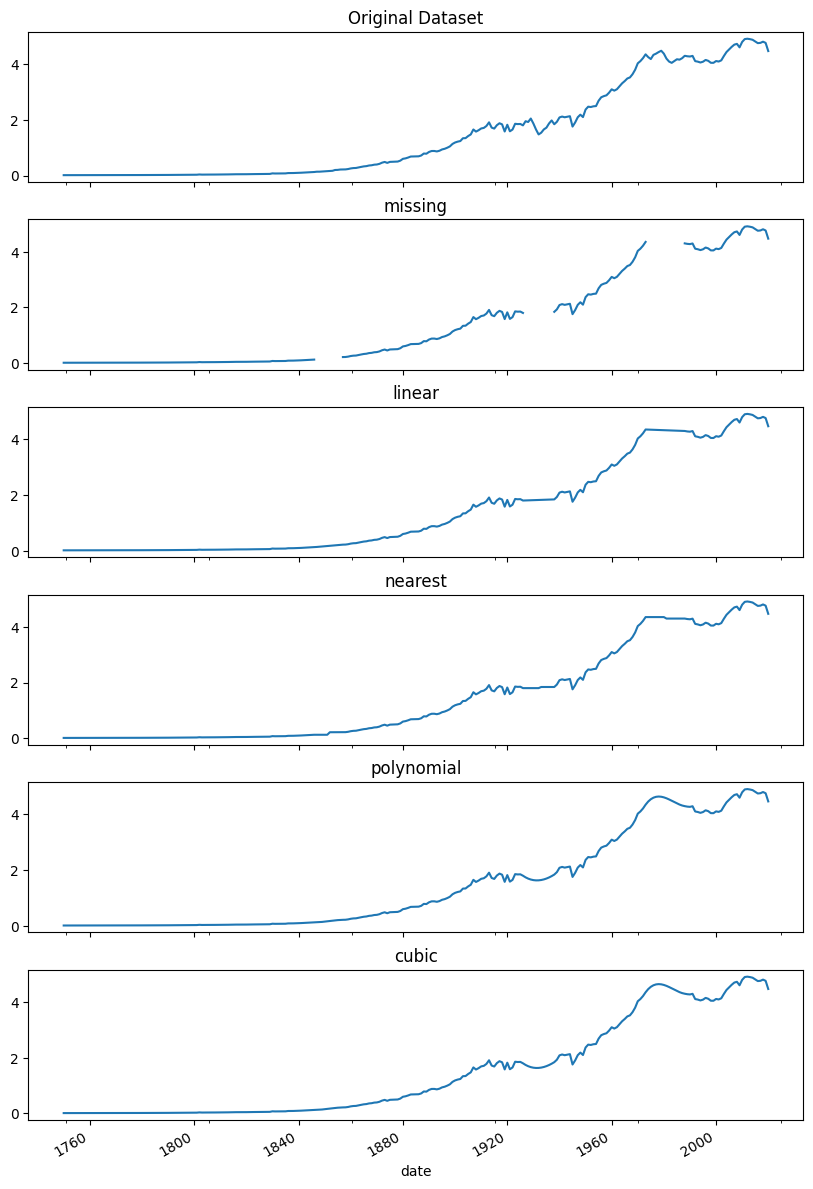

In [116]:
cols = ['co2', 'linear', 'nearest', 'polynomial', 'cubic']
plot_dfs(co2_original, co2_missing[cols], 'co2')

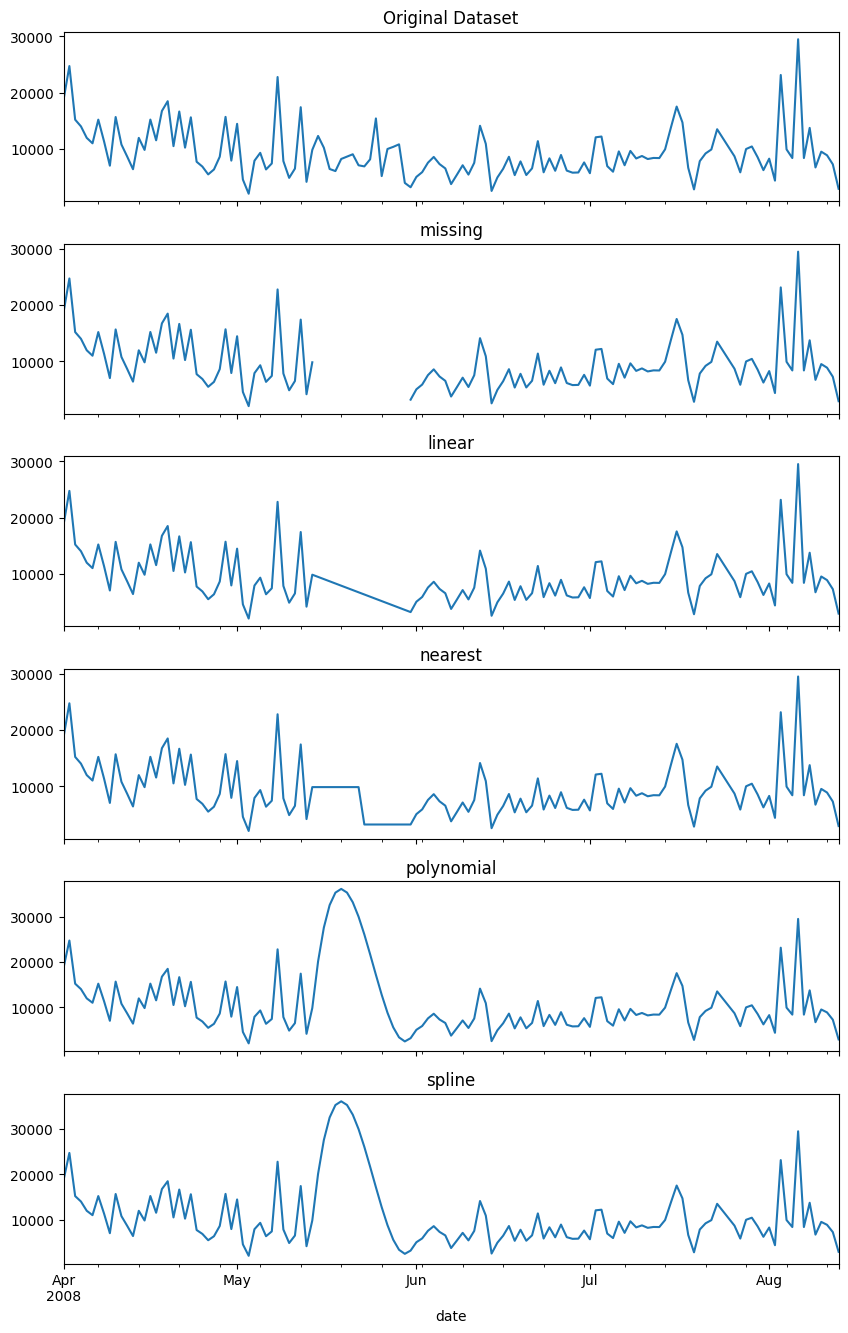

In [117]:
cols = ['clicks', 'linear', 'nearest', 'polynomial', 'spline']
plot_dfs(clicks_original, clicks_missing[cols], 'clicks')

### How it works

In [119]:
# Count the number of missing values in the 'clicks' column
clicks_missing['clicks'].isna().sum()  

16

In [120]:
# Interpolate missing values in 'clicks' column with a limit of 5 consecutive NaNs filled
example = clicks_missing['clicks'].interpolate(limit=5)  

# Count the number of remaining NaN values after interpolation with a limit of 5
example.isna().sum()  

11

Only 5 data points were imputed; the remaining 11 were not.

In [122]:
# Select all rows from May 14, 2008, onward for the 'clicks' column
clicks_missing['clicks']['2008-05-14':]  

date
2008-05-14    9841.0
2008-05-15       NaN
2008-05-16       NaN
2008-05-17       NaN
2008-05-18       NaN
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64

In [123]:
# Select all rows from May 14, 2008, onward in the 'example' Series
example['2008-05-14':]  

date
2008-05-14    9841.0
2008-05-15    9450.0
2008-05-16    9059.0
2008-05-17    8668.0
2008-05-18    8277.0
               ...  
2008-08-09    6716.0
2008-08-10    9523.0
2008-08-11    8881.0
2008-08-12    7272.0
2008-08-13    2922.0
Name: clicks, Length: 92, dtype: float64